# Introduction

The purpose of this analysis is to identify the sentiment in a series of reviews of various hotels around the United States.  I am going to identify the common language used within the reviews that will show it as either a positive or negative review and then create a set of classification models to predict the review sentiment.

I am using Hotel review information that is located here: https://www.kaggle.com/datafiniti/hotel-reviews


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import string
import spacy
import re
import seaborn as sns
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
hotels_df = pd.read_csv('Datafiniti_Hotel_Reviews_Jun19.csv', index_col=False)
hotels_df.head()

,id,dateAdded,dateUpdated,address,categories,primaryCategories,city,country,keys,latitude,...,reviews.dateSeen,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username,sourceURLs,websites
0,AWE2FvX5RxPSIh2RscTK,2018-01-18T18:43:12Z,2019-05-20T23:55:47Z,5620 Calle Real,"Hotels,Hotels and motels,Hotel and motel mgmt....",Accommodation & Food Services,Goleta,US,us/ca/goleta/5620callereal/-1127060008,34.44178,...,2018-01-03T00:00:00Z,3,https://www.tripadvisor.com/Hotel_Review-g3243...,"This hotel was nice and quiet. Did not know, t...",Best Western Plus Hotel,San Jose,UnitedStates,tatsurok2018,https://www.tripadvisor.com/Hotel_Review-g3243...,https://www.bestwestern.com/en_US/book/hotel-r...
1,AVwcj_OhkufWRAb5wi9T,2016-11-06T20:21:05Z,2019-05-20T23:31:56Z,5th And San Carlos PO Box 3574,"Hotels,Lodging,Hotel",Accommodation & Food Services,Carmel by the Sea,US,us/ca/carmelbythesea/5thandsancarlospobox3574/...,36.55722,...,2016-10-09T00:00:00Z,4,https://www.tripadvisor.com/Hotel_Review-g3217...,We stayed in the king suite with the separatio...,Clean rooms at solid rates in the heart of Carmel,San Francisco,CA,STEPHEN N,http://www.tripadvisor.com/Hotel_Review-g32172...,http://www.bestwestern.com
2,AVwcj_OhkufWRAb5wi9T,2016-11-06T20:21:05Z,2019-05-20T23:31:56Z,5th And San Carlos PO Box 3574,"Hotels,Lodging,Hotel",Accommodation & Food Services,Carmel by the Sea,US,us/ca/carmelbythesea/5thandsancarlospobox3574/...,36.55722,...,2016-10-09T00:00:00Z,3,https://www.tripadvisor.com/Hotel_Review-g3217...,"Parking was horrible, somebody ran into my ren...",Business,Prescott Valley,AZ,15Deborah,http://www.tripadvisor.com/Hotel_Review-g32172...,http://www.bestwestern.com
3,AVwcj_OhkufWRAb5wi9T,2016-11-06T20:21:05Z,2019-05-20T23:31:56Z,5th And San Carlos PO Box 3574,"Hotels,Lodging,Hotel",Accommodation & Food Services,Carmel by the Sea,US,us/ca/carmelbythesea/5thandsancarlospobox3574/...,36.55722,...,2016-10-31T00:00:00Z,5,https://www.tripadvisor.com/Hotel_Review-g3217...,Not cheap but excellent location. Price is som...,Very good,Guaynabo,PR,Wilfredo M,http://www.tripadvisor.com/Hotel_Review-g32172...,http://www.bestwestern.com
4,AVwcj_OhkufWRAb5wi9T,2016-11-06T20:21:05Z,2019-05-20T23:31:56Z,5th And San Carlos PO Box 3574,"Hotels,Lodging,Hotel",Accommodation & Food Services,Carmel by the Sea,US,us/ca/carmelbythesea/5thandsancarlospobox3574/...,36.55722,...,"2016-10-09T00:00:00Z,2016-03-27T00:00:00Z",2,https://www.tripadvisor.com/Hotel_Review-g3217...,If you get the room that they advertised on th...,Low chance to come back here,Reno,NV,Luc D,http://www.tripadvisor.com/Hotel_Review-g32172...,http://www.bestwestern.com


# Data Exploration

In [3]:
# I'm starting out by getting a total word count before I do any cleaning
hotels_df['word_count_before'] = hotels_df['reviews.text'].str.split().str.len()

In [4]:
hotels_df['word_count_before'].sum()

1179135

In [5]:
hotels_df.head()

,id,dateAdded,dateUpdated,address,categories,primaryCategories,city,country,keys,latitude,...,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username,sourceURLs,websites,word_count_before
0,AWE2FvX5RxPSIh2RscTK,2018-01-18T18:43:12Z,2019-05-20T23:55:47Z,5620 Calle Real,"Hotels,Hotels and motels,Hotel and motel mgmt....",Accommodation & Food Services,Goleta,US,us/ca/goleta/5620callereal/-1127060008,34.44178,...,3,https://www.tripadvisor.com/Hotel_Review-g3243...,"This hotel was nice and quiet. Did not know, t...",Best Western Plus Hotel,San Jose,UnitedStates,tatsurok2018,https://www.tripadvisor.com/Hotel_Review-g3243...,https://www.bestwestern.com/en_US/book/hotel-r...,39
1,AVwcj_OhkufWRAb5wi9T,2016-11-06T20:21:05Z,2019-05-20T23:31:56Z,5th And San Carlos PO Box 3574,"Hotels,Lodging,Hotel",Accommodation & Food Services,Carmel by the Sea,US,us/ca/carmelbythesea/5thandsancarlospobox3574/...,36.55722,...,4,https://www.tripadvisor.com/Hotel_Review-g3217...,We stayed in the king suite with the separatio...,Clean rooms at solid rates in the heart of Carmel,San Francisco,CA,STEPHEN N,http://www.tripadvisor.com/Hotel_Review-g32172...,http://www.bestwestern.com,61
2,AVwcj_OhkufWRAb5wi9T,2016-11-06T20:21:05Z,2019-05-20T23:31:56Z,5th And San Carlos PO Box 3574,"Hotels,Lodging,Hotel",Accommodation & Food Services,Carmel by the Sea,US,us/ca/carmelbythesea/5thandsancarlospobox3574/...,36.55722,...,3,https://www.tripadvisor.com/Hotel_Review-g3217...,"Parking was horrible, somebody ran into my ren...",Business,Prescott Valley,AZ,15Deborah,http://www.tripadvisor.com/Hotel_Review-g32172...,http://www.bestwestern.com,54
3,AVwcj_OhkufWRAb5wi9T,2016-11-06T20:21:05Z,2019-05-20T23:31:56Z,5th And San Carlos PO Box 3574,"Hotels,Lodging,Hotel",Accommodation & Food Services,Carmel by the Sea,US,us/ca/carmelbythesea/5thandsancarlospobox3574/...,36.55722,...,5,https://www.tripadvisor.com/Hotel_Review-g3217...,Not cheap but excellent location. Price is som...,Very good,Guaynabo,PR,Wilfredo M,http://www.tripadvisor.com/Hotel_Review-g32172...,http://www.bestwestern.com,52
4,AVwcj_OhkufWRAb5wi9T,2016-11-06T20:21:05Z,2019-05-20T23:31:56Z,5th And San Carlos PO Box 3574,"Hotels,Lodging,Hotel",Accommodation & Food Services,Carmel by the Sea,US,us/ca/carmelbythesea/5thandsancarlospobox3574/...,36.55722,...,2,https://www.tripadvisor.com/Hotel_Review-g3217...,If you get the room that they advertised on th...,Low chance to come back here,Reno,NV,Luc D,http://www.tripadvisor.com/Hotel_Review-g32172...,http://www.bestwestern.com,61


In [6]:
hotels_df_full = hotels_df

In [7]:
hotels_df.columns

Index(['id', 'dateAdded', 'dateUpdated', 'address', 'categories',
       'primaryCategories', 'city', 'country', 'keys', 'latitude', 'longitude',
       'name', 'postalCode', 'province', 'reviews.date', 'reviews.dateAdded',
       'reviews.dateSeen', 'reviews.rating', 'reviews.sourceURLs',
       'reviews.text', 'reviews.title', 'reviews.userCity',
       'reviews.userProvince', 'reviews.username', 'sourceURLs', 'websites',
       'word_count_before'],
      dtype='object')

In [8]:
hotels_df.shape

(10000, 27)

In [9]:
hotels_df.isnull().sum()

id                          0
dateAdded                   0
dateUpdated                 0
address                     0
categories                  0
primaryCategories           0
city                        0
country                     0
keys                        0
latitude                    0
longitude                   0
name                        0
postalCode                  0
province                    0
reviews.date                0
reviews.dateAdded       10000
reviews.dateSeen            0
reviews.rating              0
reviews.sourceURLs          0
reviews.text                0
reviews.title               1
reviews.userCity            0
reviews.userProvince        2
reviews.username            0
sourceURLs                  0
websites                    0
word_count_before           0
dtype: int64

### Locations

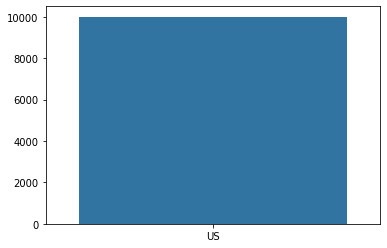

In [10]:
country = hotels_df['country'].value_counts()
sns.barplot(country.index, country.values)

All the hotels in this data are in the United States.

In [11]:
hotels_df['city'].nunique()

842

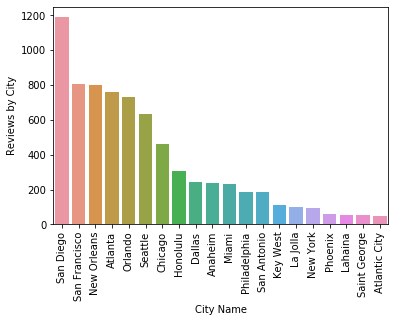

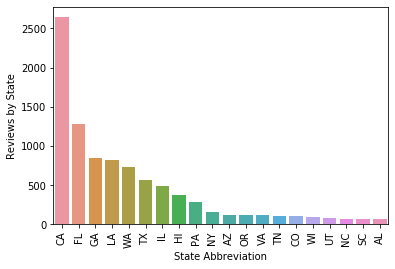

In [12]:
city_counts = hotels_df['city'].value_counts()[:20]
sns.barplot(city_counts.index, city_counts.values)
plt.ylabel('Reviews by City')
plt.xlabel('City Name')
plt.xticks(rotation='vertical')
plt.show()

state_counts = hotels_df['province'].value_counts()[:20]
sns.barplot(state_counts.index, state_counts.values)
plt.ylabel('Reviews by State')
plt.xlabel('State Abbreviation')
plt.xticks(rotation='vertical')
plt.show()

### Hotels

In [13]:
hotels_df['name'].value_counts()

Hyatt House Seattle/Downtown                          209
Hotel Emma                                            183
French Market Inn                                     144
St. James Hotel, an Ascend Hotel Collection Member    136
Grand Hyatt Seattle                                   135
                                                     ... 
Super 8-Fernley                                         1
Hampton Inn-lindale/tyler                               1
Comfort Inn Humboldt Bay                                1
Granzellas Inn                                          1
Hampton Inn-longmont                                    1
Name: name, Length: 1311, dtype: int64

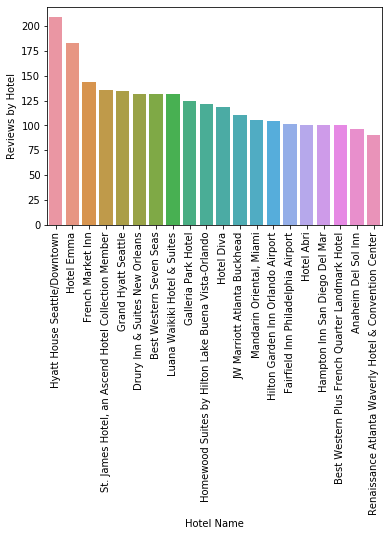

In [14]:
hotel_counts = hotels_df['name'].value_counts()[:20]
sns.barplot(hotel_counts.index, hotel_counts.values)
plt.ylabel('Reviews by Hotel')
plt.xlabel('Hotel Name')
plt.xticks(rotation='vertical')
plt.show()

There are 1311 different hotels in this database and they are from a wide range of locations within the United States.  This validates the data because it isn't condensed into a small number of states/hotels.

## Target Variable
Since the goal of my project is to identify the common language in reviews I only need to work with the reviews.rating and the reviews.text columns of this dataset.  There are no missing values in either of those columns.  I am going to keep my word_count_before column for comparison and will be dropping it before I do any modeling.

In [15]:
hotels_df = hotels_df[['reviews.rating', 'reviews.text', 'word_count_before']]
hotels_df.head()

,reviews.rating,reviews.text,word_count_before
0,3,"This hotel was nice and quiet. Did not know, t...",39
1,4,We stayed in the king suite with the separatio...,61
2,3,"Parking was horrible, somebody ran into my ren...",54
3,5,Not cheap but excellent location. Price is som...,52
4,2,If you get the room that they advertised on th...,61


# Data Cleaning, Data Exploration, and Feature Engineering

I need to identify what would be considered a "positive" review and what would be "negative."

In [16]:
hotels_df.nunique()

reviews.rating          5
reviews.text         9770
word_count_before     551
dtype: int64

In [17]:
hotels_df['reviews.rating'].value_counts()

5    4840
4    2849
3    1190
1     567
2     554
Name: reviews.rating, dtype: int64

Text(0.5, 1.0, 'Number of review scores by rating')

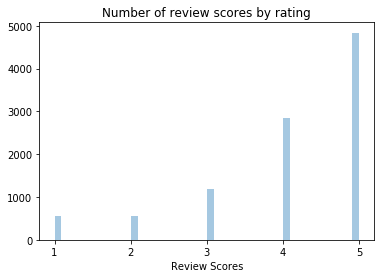

In [18]:
sns.distplot(hotels_df['reviews.rating'], kde=False)
plt.xticks([1,2,3,4,5])
plt.xlabel('Review Scores')
plt.title('Number of review scores by rating')

This shows me that there are 5 different ratings for a hotel.  Based on the rating system, the number of different values I'm working with, and the review text that I have sampled I am going to classify the values of 1,2, and 3 as the "negative" classification and 4 and 5 as the "positive."  I'm going to create a new column to illustrate this. 

In [19]:
ranking = []
for rating in hotels_df['reviews.rating']:
    if rating == 1 or rating == 2 or rating == 3:
        ranking.append('Negative')
    else:
        ranking.append('Positive')


In [20]:
print(ranking[:5])

['Negative', 'Positive', 'Negative', 'Positive', 'Negative']


In [21]:
hotels_df['ranking'] = ranking

In [22]:
hotels_df.drop(['reviews.rating'], axis=1, inplace=True)

In [23]:
hotels_df.head()

,reviews.text,word_count_before,ranking
0,"This hotel was nice and quiet. Did not know, t...",39,Negative
1,We stayed in the king suite with the separatio...,61,Positive
2,"Parking was horrible, somebody ran into my ren...",54,Negative
3,Not cheap but excellent location. Price is som...,52,Positive
4,If you get the room that they advertised on th...,61,Negative


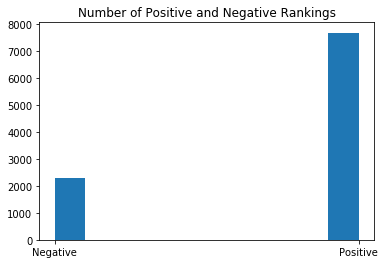

In [24]:
plt.hist(hotels_df['ranking'])
plt.title('Number of Positive and Negative Rankings')
plt.show()

In [25]:
# I am renaming the columns here because I don't like that they have a .
# inbetween the words
hotels_df.rename(columns={'reviews.text': 'text'}, inplace=True)

In [26]:
hotels_df.columns

Index(['text', 'word_count_before', 'ranking'], dtype='object')

Now I have a binary system that I can use to identify whether a guest had a positive or negative experience at the hotel they stayed at.  It is very clear that I have a large discrepency between the positive and negative reviews.  I have my dataframe down to the columns that I need and now I am going to start cleaning and tokenizing the text within each review.

# Text Preprocessing

In [27]:
hotels_df.head()

,text,word_count_before,ranking
0,"This hotel was nice and quiet. Did not know, t...",39,Negative
1,We stayed in the king suite with the separatio...,61,Positive
2,"Parking was horrible, somebody ran into my ren...",54,Negative
3,Not cheap but excellent location. Price is som...,52,Positive
4,If you get the room that they advertised on th...,61,Negative


### Removing Punctuation

In [28]:
# Removing the Punctuation from my text
def remove_punctuation(text):
    no_punct = ''.join([c for c in text if c not in string.punctuation])
    return no_punct.lower()

In [29]:
hotels_df['text'] = hotels_df.apply(lambda x: remove_punctuation(x['text']), axis=1)
hotels_df['text'].head()

0    this hotel was nice and quiet did not know the...
1    we stayed in the king suite with the separatio...
2    parking was horrible somebody ran into my rent...
3    not cheap but excellent location price is some...
4    if you get the room that they advertised on th...
Name: text, dtype: object

### Tokenizing the Text

In [30]:
tokenizer = RegexpTokenizer(r"[\w']+")

In [31]:
hotels_df['text'] = hotels_df['text'].apply(lambda x: tokenizer.tokenize(x))
hotels_df['text'].head()

0    [this, hotel, was, nice, and, quiet, did, not,...
1    [we, stayed, in, the, king, suite, with, the, ...
2    [parking, was, horrible, somebody, ran, into, ...
3    [not, cheap, but, excellent, location, price, ...
4    [if, you, get, the, room, that, they, advertis...
Name: text, dtype: object

In [32]:
length_token = hotels_df['text'].str.len()
length_token

0       39
1       61
2       54
3       52
4       60
        ..
9995    61
9996    45
9997    50
9998    35
9999    38
Name: text, Length: 10000, dtype: int64

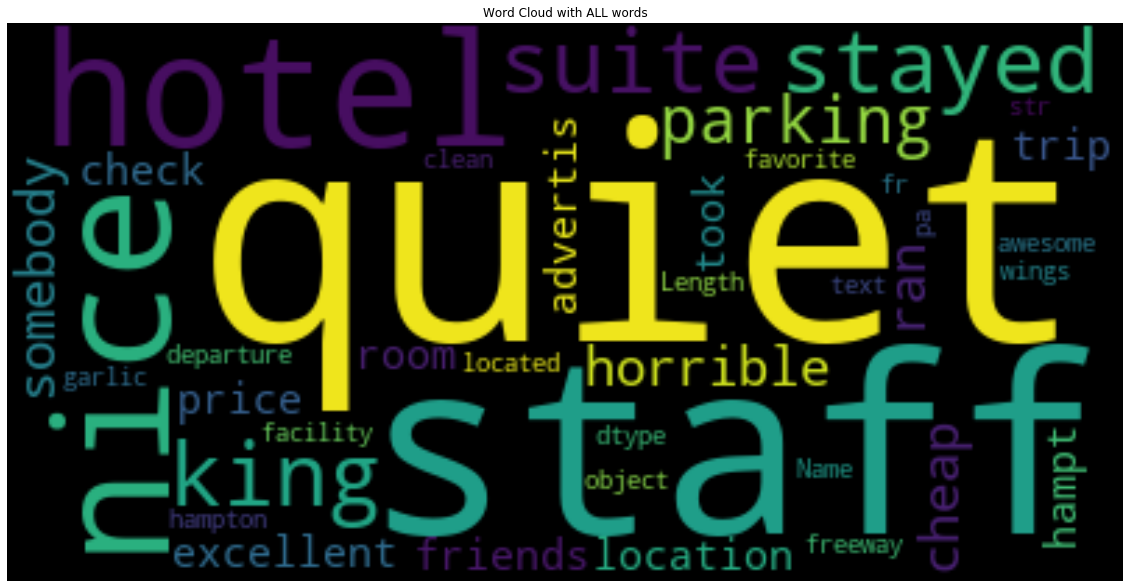

In [33]:
plt.figure(figsize=(20,20))
text = str(hotels_df['text'])

wordcloud = WordCloud().generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud with ALL words')
plt.show()

### Removing the Stopwords

In [34]:
def remove_stopwords(text):
    words = [word for word in text if word not in stopwords.words('english')]
    return words

In [35]:
hotels_df['text'] = hotels_df['text'].apply(lambda x: remove_stopwords(x))
hotels_df['text'].head()

0    [hotel, nice, quiet, know, train, track, near,...
1    [stayed, king, suite, separation, bedroom, liv...
2    [parking, horrible, somebody, ran, rental, car...
3    [cheap, excellent, location, price, somewhat, ...
4    [get, room, advertised, website, paid, may, lu...
Name: text, dtype: object

In [36]:
length_stop = hotels_df['text'].str.len()
length_stop

0       17
1       30
2       25
3       28
4       31
        ..
9995    27
9996    23
9997    29
9998    19
9999    23
Name: text, Length: 10000, dtype: int64

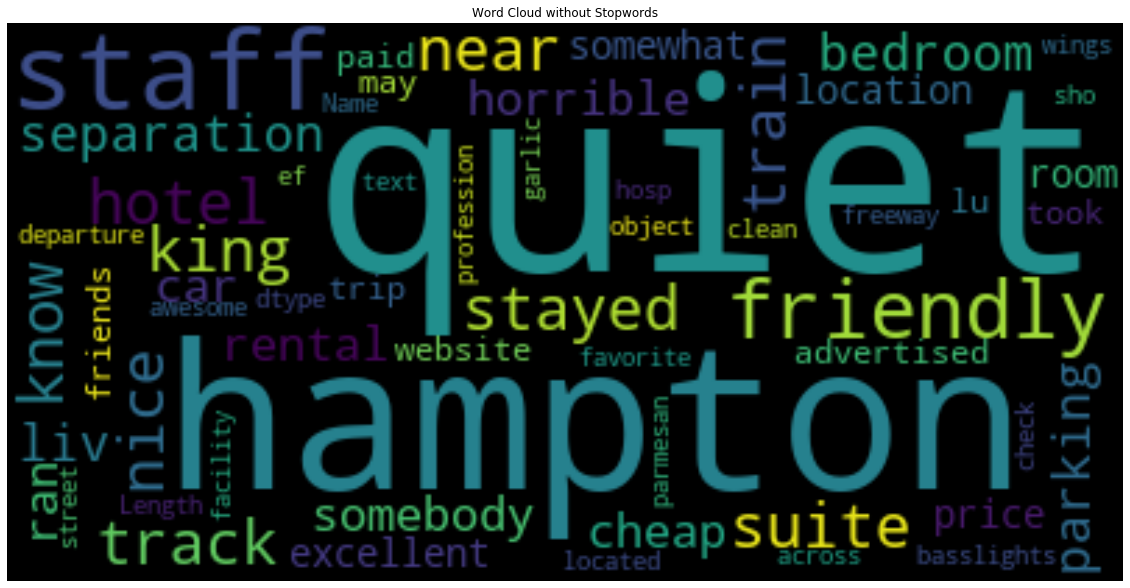

In [37]:
plt.figure(figsize=(20,20))
text = str(hotels_df['text'])

wordcloud = WordCloud().generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud without Stopwords')
plt.show()

## Lemmatization and their Frequencies

In [38]:
# Lemmatization
lemmatizer = WordNetLemmatizer()

def word_lemmatizer(text):
    lemmas = [lemmatizer.lemmatize(i) for i in text]
    return lemmas

In [39]:
hotels_df['text'].apply(lambda x: word_lemmatizer(x))

0       [hotel, nice, quiet, know, train, track, near,...
1       [stayed, king, suite, separation, bedroom, liv...
2       [parking, horrible, somebody, ran, rental, car...
3       [cheap, excellent, location, price, somewhat, ...
4       [get, room, advertised, website, paid, may, lu...
                              ...                        
9995    [friend, took, trip, hampton, basslights, show...
9996    [check, departure, staff, friendly, profession...
9997    [hampton, located, quiet, street, across, hosp...
9998    [awesome, wing, favorite, garlic, parmesan, gr...
9999    [clean, facility, freeway, staff, friendly, ef...
Name: text, Length: 10000, dtype: object

In [40]:
hotels_df['word_count_after'] = hotels_df['text'].str.len()


In [41]:
hotels_df.head()

,text,word_count_before,ranking,word_count_after
0,"[hotel, nice, quiet, know, train, track, near,...",39,Negative,17
1,"[stayed, king, suite, separation, bedroom, liv...",61,Positive,30
2,"[parking, horrible, somebody, ran, rental, car...",54,Negative,25
3,"[cheap, excellent, location, price, somewhat, ...",52,Positive,28
4,"[get, room, advertised, website, paid, may, lu...",61,Negative,31


In [42]:
print(hotels_df['word_count_before'].sum())
print(hotels_df['word_count_after'].sum())

1179135
607351


In [43]:
# Now I can drop the columns I don't need
hotels_df.drop(['word_count_before', 'word_count_after'], axis=1, inplace=True)

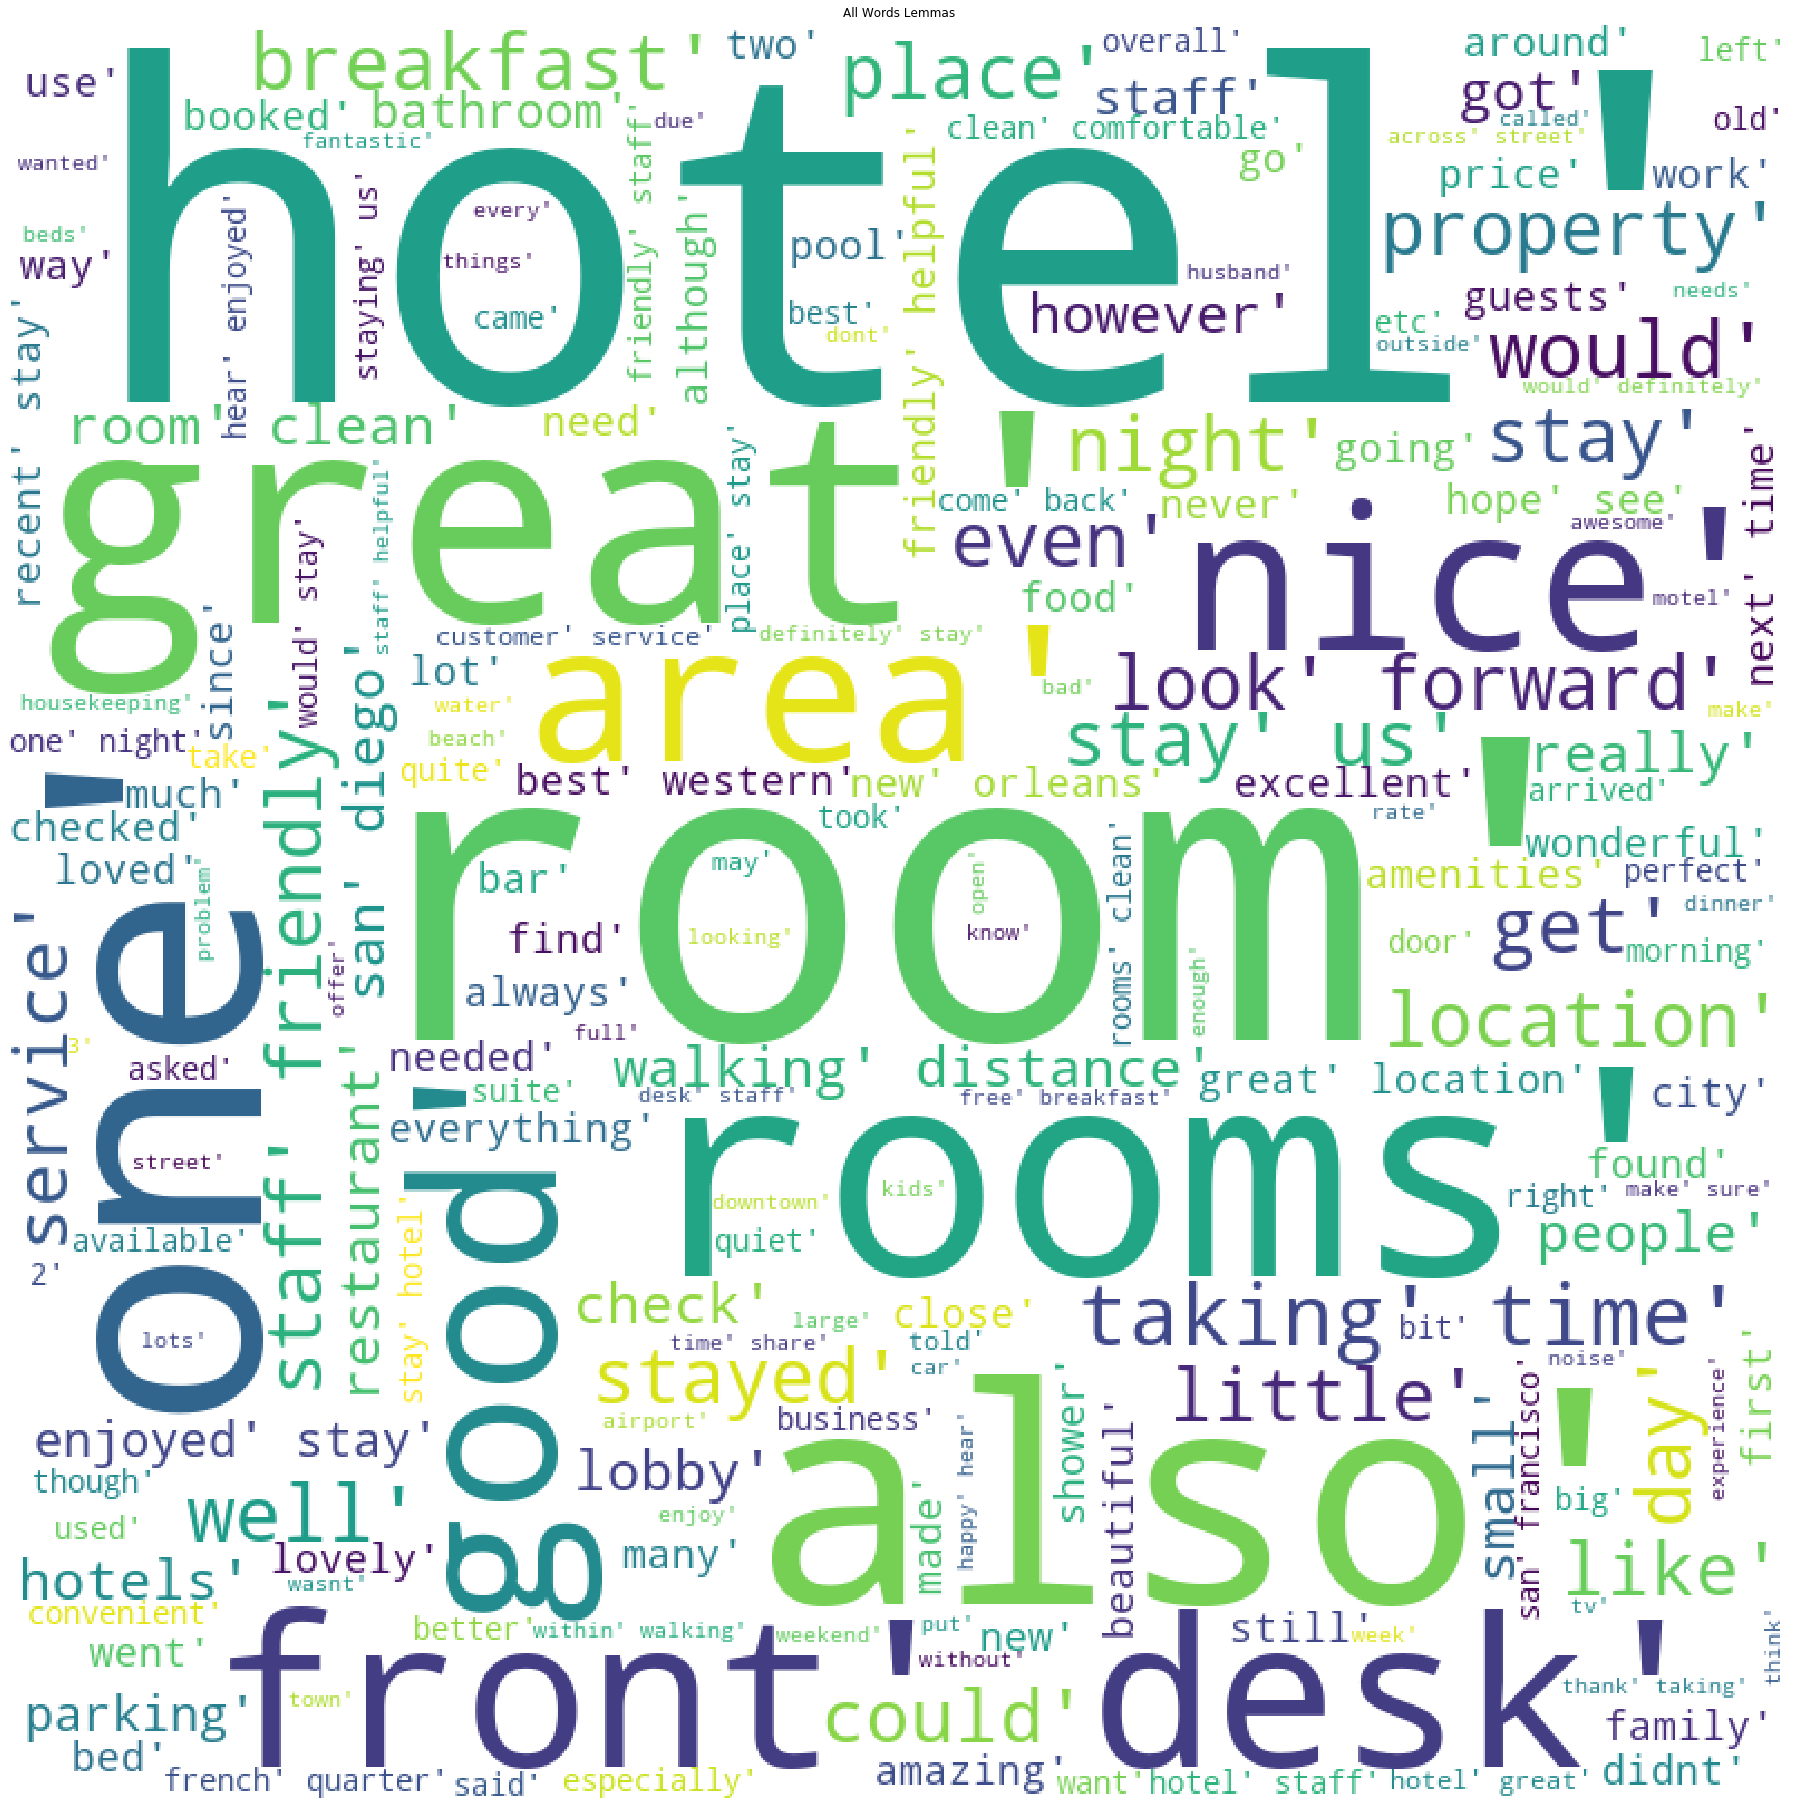

In [44]:
comment_words = ' '
stopwords = set(STOPWORDS)

for val in hotels_df.text:
    val = str(val)
    tokens = val.split()
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
        
    for words in tokens:
        comment_words = comment_words + words + ' '

wordcloud = WordCloud(width = 800, height = 800,
                     background_color = 'white',
                     stopwords = stopwords,
                     min_font_size = 10).generate(comment_words)

plt.figure(figsize=(25,25))

plt.imshow(wordcloud)
plt.axis('off')
plt.title('All Words Lemmas')
plt.tight_layout(pad = 0)
plt.show()

In [45]:
# The word hotel is by far the most common and doesn't really add anything
# and is just adding noise to the data
hotels_df['text'] = hotels_df['text'].apply(str)
def remove_hotel(text):
    result = re.sub('hotel', '', text)
    return result
hotels_df['text'] = hotels_df['text'].apply(lambda x: remove_hotel(x))

In [47]:
result = Counter(" ".join(hotels_df['text'].values.tolist()).split(" ")).items() 
def sorting_list(sub_li):
    sub_li.sort(key = lambda x: x[1], reverse=True)
    return sub_li

print(sorting_list(list(result)[:20]))

[("'',", 10922), ("'stay',", 7117), ("'nice',", 3584), ("'best',", 1706), ("['stayed',", 1165), ("'know',", 1031), ("'quiet',", 933), ("['',", 760), ("'near',", 717), ("'suite',", 620), ("'western',", 577), ("'plus',", 482), ("'king',", 376), ("'train',", 141), ("'changed',", 109), ("'passed',", 56), ("'track',", 30), ("'classification',", 1), ("'category']", 1), ("'separation',", 1)]


In [48]:
hotels_df.head()

,text,ranking
0,"['', 'nice', 'quiet', 'know', 'train', 'track'...",Negative
1,"['stayed', 'king', 'suite', 'separation', 'bed...",Positive
2,"['parking', 'horrible', 'somebody', 'ran', 're...",Negative
3,"['cheap', 'excellent', 'location', 'price', 's...",Positive
4,"['get', 'room', 'advertised', 'website', 'paid...",Negative


Since most of my data is positive reviews it makes sense that words like 'great', 'nice', 'good', 'friendly', etc. are the most common.  I am going to split my reviews into the Positive and Negative so that I can get a better idea of the language used that is specific to each sentiment.

## Splitting the Positive and Negative and Examining them separately

### Positive Reviews

In [49]:
hotels_df_pos = hotels_df[(hotels_df['ranking'] == 'Positive')]
hotels_df_pos.head()

,text,ranking
1,"['stayed', 'king', 'suite', 'separation', 'bed...",Positive
3,"['cheap', 'excellent', 'location', 'price', 's...",Positive
5,"['fun', 'lovely', '', 'attention', 'detail', '...",Positive
8,['moremore'],Positive
10,"['new', 'hampton', 'inn', 'well', 'decorated',...",Positive


In [51]:
hotels_df_pos['text']=hotels_df_pos['text'].astype(str)
result = Counter(" ".join(hotels_df_pos['text'].values.tolist()).split(" ")).items() 
def sorting_list(sub_li):
    sub_li.sort(key = lambda x: x[1], reverse=True)
    return sub_li

print(sorting_list(list(result)[:20]))



[("'room',", 6232), ("'stay',", 5479), ("'clean',", 3278), ("'good',", 2543), ("'back',", 1831), ("'night',", 1303), ("'day',", 1018), ("'bed',", 995), ("['stayed',", 928), ("'suite',", 512), ("'space',", 467), ("'king',", 274), ("'wasnt',", 265), ("'three',", 233), ("'bedroom',", 229), ("'left',", 208), ("'living',", 166), ("'sofa',", 97), ("'separation',", 1), ("'discomfort',", 1)]


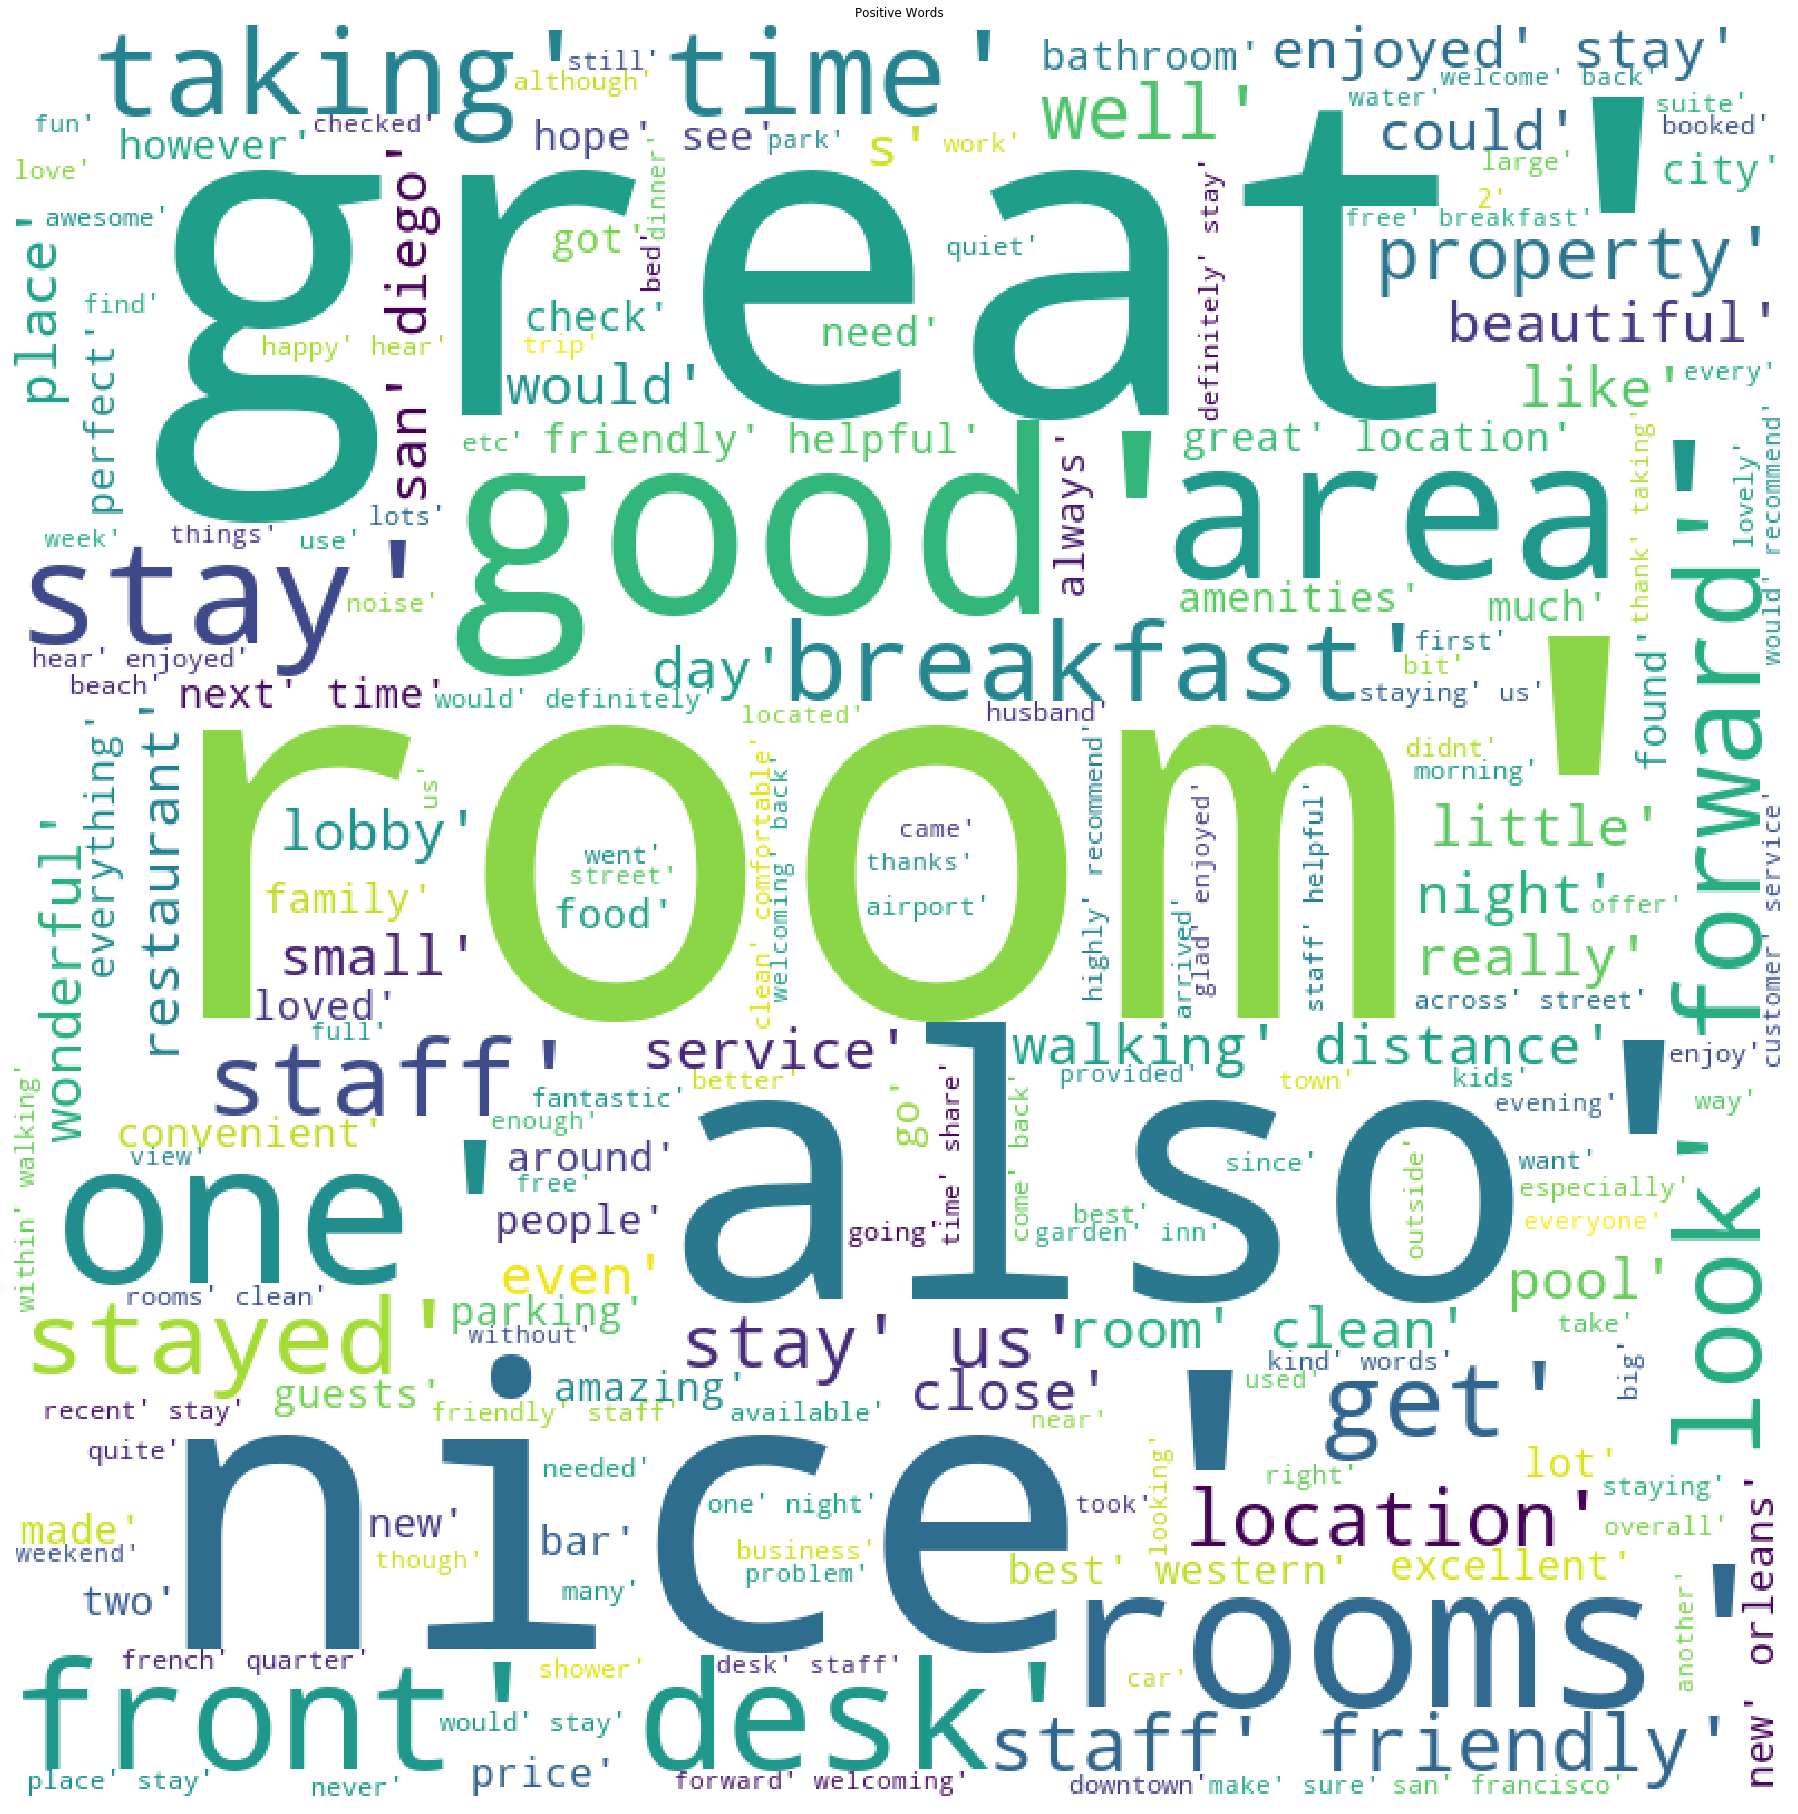

In [52]:
comment_words = ' '
stopwords = set(STOPWORDS)

for val in hotels_df_pos['text']:
    val = str(val)
    tokens = val.split()
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
        
    for words in tokens:
        comment_words = comment_words + words + ' '

wordcloud = WordCloud(width = 800, height = 800,
                     background_color = 'white',
                     stopwords = stopwords,
                     min_font_size = 10).generate(comment_words)

plt.figure(figsize=(25,25))

plt.imshow(wordcloud)
plt.axis('off')
plt.title('Positive Words')
plt.tight_layout(pad = 0)
plt.show()

### Negative Reviews

In [53]:
hotels_df_neg = hotels_df[(hotels_df['ranking'] == 'Negative')]
hotels_df_neg.head()

,text,ranking
0,"['', 'nice', 'quiet', 'know', 'train', 'track'...",Negative
2,"['parking', 'horrible', 'somebody', 'ran', 're...",Negative
4,"['get', 'room', 'advertised', 'website', 'paid...",Negative
6,"['recently', 'stayed', '', 'trip', 'lexington'...",Negative
7,"['reserved', 'room', 'week', 'advance', 'knowi...",Negative


In [54]:
hotels_df_neg['text']=hotels_df_neg['text'].astype(str)
result = Counter(" ".join(hotels_df_neg['text'].values.tolist()).split(" ")).items() 
def sorting_list(sub_li):
    sub_li.sort(key = lambda x: x[1], reverse=True)
    return sub_li

print(sorting_list(list(result)[:20]))

[("'',", 2838), ("'stay',", 1638), ("'nice',", 679), ("'best',", 363), ("'know',", 327), ("['',", 161), ("'western',", 153), ("'near',", 141), ("'quiet',", 114), ("'plus',", 96), ("'horrible',", 75), ("'changed',", 45), ("'ran',", 43), ("'train',", 25), ("'passed',", 22), ("'track',", 10), ("'somebody',", 7), ("['parking',", 5), ("'classification',", 1), ("'category']", 1)]


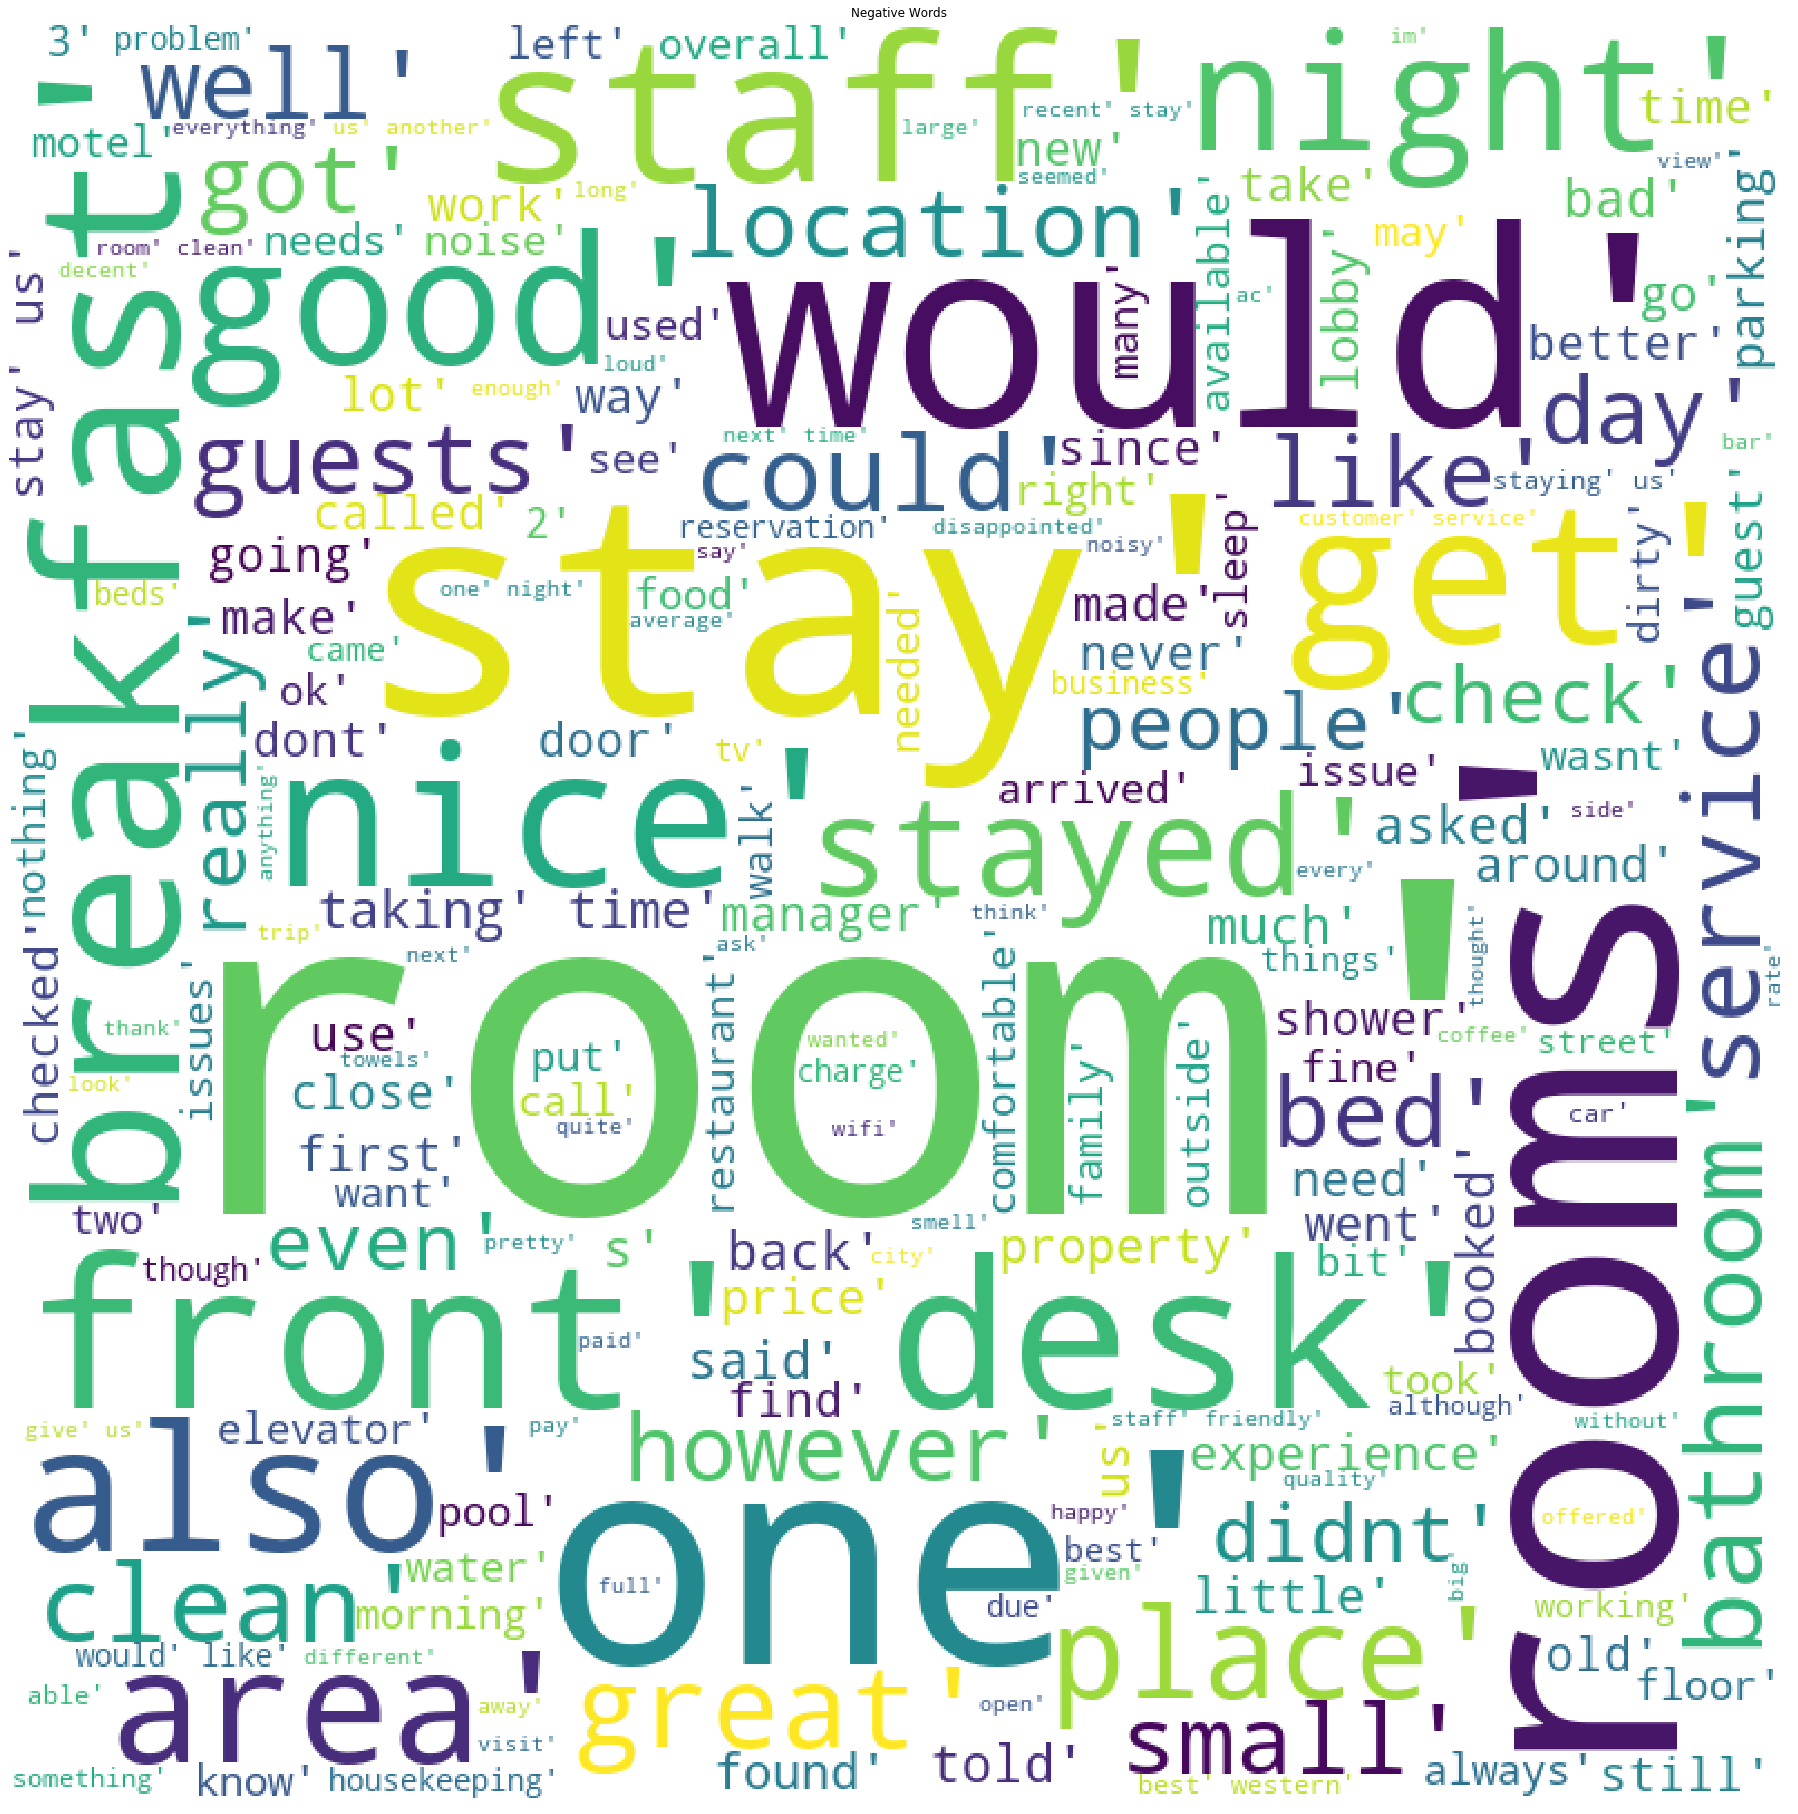

In [55]:
# Now I will do another word cloud for the negative words
comment_words = ' '
stopwords = set(STOPWORDS)

for val in hotels_df_neg.text:
    val = str(val)
    tokens = val.split()
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
        
    for words in tokens:
        comment_words = comment_words + words + ' '

wordcloud = WordCloud(width = 800, height = 800,
                     background_color = 'white',
                     stopwords = stopwords,
                     min_font_size = 10).generate(comment_words)

plt.figure(figsize=(25,25))

plt.imshow(wordcloud)
plt.axis('off')
plt.title('Negative Words')
plt.tight_layout(pad = 0)
plt.show()

# Using Bag of Words for Classification Models

In [56]:
hotels_df['text_string'] = [' '.join(map(str, l)) for l in hotels_df['text']]
hotels_df.head()

,text,ranking,text_string
0,"['', 'nice', 'quiet', 'know', 'train', 'track'...",Negative,"[ ' ' , ' n i c e ' , ' q u i e t ' , ' ..."
1,"['stayed', 'king', 'suite', 'separation', 'bed...",Positive,"[ ' s t a y e d ' , ' k i n g ' , ' s u i ..."
2,"['parking', 'horrible', 'somebody', 'ran', 're...",Negative,"[ ' p a r k i n g ' , ' h o r r i b l e ' , ..."
3,"['cheap', 'excellent', 'location', 'price', 's...",Positive,"[ ' c h e a p ' , ' e x c e l l e n t ' , ..."
4,"['get', 'room', 'advertised', 'website', 'paid...",Negative,"[ ' g e t ' , ' r o o m ' , ' a d v e r t ..."


In [57]:
X = hotels_df['text']
y = hotels_df['ranking']

In [58]:
print(X)

0       ['', 'nice', 'quiet', 'know', 'train', 'track'...
1       ['stayed', 'king', 'suite', 'separation', 'bed...
2       ['parking', 'horrible', 'somebody', 'ran', 're...
3       ['cheap', 'excellent', 'location', 'price', 's...
4       ['get', 'room', 'advertised', 'website', 'paid...
                              ...                        
9995    ['friends', 'took', 'trip', 'hampton', 'bassli...
9996    ['check', 'departure', 'staff', 'friendly', 'p...
9997    ['hampton', 'located', 'quiet', 'street', 'acr...
9998    ['awesome', 'wings', 'favorite', 'garlic', 'pa...
9999    ['clean', 'facility', 'freeway', 'staff', 'fri...
Name: text, Length: 10000, dtype: object


In [59]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(lowercase=False)
X = cv.fit_transform(X)
bow_df = pd.DataFrame(X.toarray(), columns=cv.get_feature_names())



In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=16)

In [61]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
print(lr.coef_)

[[-0.02126671 -0.02634926  0.         ...  0.09968424  0.01518903
   0.01543808]]


In [62]:
rfc = RandomForestClassifier(n_estimators=5, max_depth=2, random_state=16)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=2, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=5,
                       n_jobs=None, oob_score=False, random_state=16, verbose=0,
                       warm_start=False)

In [63]:
gbc = GradientBoostingClassifier(n_estimators=20, max_depth=2, max_leaf_nodes=2)
gbc.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=2,
                           max_features=None, max_leaf_nodes=2,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=20,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [64]:
print("----------------------Logistic Regression Scores----------------------")
print('Training set score:', lr.score(X_train, y_train))
print('Test set score:', lr.score(X_test, y_test))

print("----------------------Random Forest Scores----------------------")
print('Training set score:', rfc.score(X_train, y_train))
print('Test set score:', rfc.score(X_test, y_test))

print("----------------------Gradient Boosting Scores----------------------")
print('Training set score:', gbc.score(X_train, y_train))
print('Test set score:', gbc.score(X_test, y_test))

----------------------Logistic Regression Scores----------------------
Training set score: 0.9921333333333333
Test set score: 0.8808
----------------------Random Forest Scores----------------------
Training set score: 0.7657333333333334
Test set score: 0.7792
----------------------Gradient Boosting Scores----------------------
Training set score: 0.7826666666666666
Test set score: 0.7968


It is very clear that the Logistic Regression Model did very well on the test data but there is pretty clear overfitting.  I want to see if I can address the overfitting by running a Cross-Validation model.

In [65]:
lr_cv = LogisticRegressionCV(cv=5, random_state=16).fit(X_train, y_train)
print(lr_cv.score(X_train, y_train))
print(lr_cv.score(X_test, y_test))

0.9305333333333333
0.8876


There is much less overfitting with the cross-validation model here.  I am going to try a couple of other models to see if I can improve on my score.

## Using 2-grams Bag of Words

In [66]:
X = hotels_df['text']
y = hotels_df['ranking']

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=16)

In [68]:
cv = CountVectorizer(analyzer='word',max_df=.5, min_df=5, lowercase=False, ngram_range=(2,2))
X = cv.fit_transform(X)
bow_df = pd.DataFrame(X.toarray(), columns=cv.get_feature_names())

In [69]:
bow_df['text'] = hotels_df['text']
bow_df['ranking'] = hotels_df['ranking']

In [70]:
bow_df.head()

,10 15,10 days,10 min,10 mins,10 minute,10 minutes,10 pm,10 years,100 night,101 exceed,...,youre traveling,yoursandrew may,youve enjoyed,youve got,youyours hospitalitypaulette,yr old,zacks bar,zoo seaworld,text,ranking
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"['', 'nice', 'quiet', 'know', 'train', 'track'...",Negative
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"['stayed', 'king', 'suite', 'separation', 'bed...",Positive
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"['parking', 'horrible', 'somebody', 'ran', 're...",Negative
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"['cheap', 'excellent', 'location', 'price', 's...",Positive
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"['get', 'room', 'advertised', 'website', 'paid...",Negative


In [71]:
y = bow_df['ranking']
X = np.array(bow_df.drop(['text', 'ranking'], 1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=16)

In [72]:
lr_grams = LogisticRegression()
lr_grams.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [73]:
rfc_grams = RandomForestClassifier(n_estimators=5, max_depth=2, random_state=16)
rfc_grams.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=2, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=5,
                       n_jobs=None, oob_score=False, random_state=16, verbose=0,
                       warm_start=False)

In [74]:
gbc_grams = GradientBoostingClassifier(n_estimators=20, max_depth=2, max_leaf_nodes=2)
gbc_grams.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=2,
                           max_features=None, max_leaf_nodes=2,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=20,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [75]:
print("----------------------Logistic Regression Scores----------------------")
print('Training set score 2 n-grams:', lr_grams.score(X_train, y_train))
print('Test set score 2 n-grams:', lr_grams.score(X_test, y_test))

print("----------------------Random Forest Scores----------------------")
print('Training set score 2 n-grams:', rfc_grams.score(X_train, y_train))
print('Test set score 2 n-grams:', rfc_grams.score(X_test, y_test))

print("----------------------Gradient Boosting Scores----------------------")
print('Training set score 2 n-grams:', gbc_grams.score(X_train, y_train))
print('Test set score 2 n-grams:', gbc_grams.score(X_test, y_test))

----------------------Logistic Regression Scores----------------------
Training set score 2 n-grams: 0.9898666666666667
Test set score 2 n-grams: 0.864
----------------------Random Forest Scores----------------------
Training set score 2 n-grams: 0.7664
Test set score 2 n-grams: 0.7796
----------------------Gradient Boosting Scores----------------------
Training set score 2 n-grams: 0.7770666666666667
Test set score 2 n-grams: 0.7848


In [76]:
lr_cv_n2 = LogisticRegressionCV(cv=5, random_state=16).fit(X_train, y_train)
print(lr_cv_n2.score(X_train, y_train))
print(lr_cv_n2.score(X_test, y_test))

0.9961333333333333
0.8588


The 2 n-grams models have similar scores except the Cross-Validation Logistic Regression model didn't improve compared to the non-CV version

# Using Tfidf for Classification Models

In [77]:
hotels_df['text']

0       ['', 'nice', 'quiet', 'know', 'train', 'track'...
1       ['stayed', 'king', 'suite', 'separation', 'bed...
2       ['parking', 'horrible', 'somebody', 'ran', 're...
3       ['cheap', 'excellent', 'location', 'price', 's...
4       ['get', 'room', 'advertised', 'website', 'paid...
                              ...                        
9995    ['friends', 'took', 'trip', 'hampton', 'bassli...
9996    ['check', 'departure', 'staff', 'friendly', 'p...
9997    ['hampton', 'located', 'quiet', 'street', 'acr...
9998    ['awesome', 'wings', 'favorite', 'garlic', 'pa...
9999    ['clean', 'facility', 'freeway', 'staff', 'fri...
Name: text, Length: 10000, dtype: object

In [78]:
vectorizer = TfidfVectorizer(
    max_df=.5, min_df=4, use_idf=True, norm=u'l2', smooth_idf=True, ngram_range=(2,2), lowercase=False)
hotels_df['text']=hotels_df['text'].astype(str)
# Applying the vectorizer
X = vectorizer.fit_transform(hotels_df['text'])

tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())

In [79]:
tfidf_df['ranking'] = hotels_df['ranking']

In [80]:
tfidf_df.head()

,10 15,10 blocks,10 day,10 days,10 discount,10 hours,10 min,10 mins,10 minute,10 minutes,...,youre welcome,yoursandrew may,youve enjoyed,youve got,youve stayed,youyours hospitalitypaulette,yr old,zacks bar,zoo seaworld,ranking
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Negative
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Positive
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Negative
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Positive
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Negative


In [81]:
y = tfidf_df['ranking']
X = tfidf_df.drop(['ranking'], 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=16)

In [82]:
print(X)

      10 15  10 blocks  10 day  10 days  10 discount  10 hours  10 min  \
0       0.0        0.0     0.0      0.0          0.0       0.0     0.0   
1       0.0        0.0     0.0      0.0          0.0       0.0     0.0   
2       0.0        0.0     0.0      0.0          0.0       0.0     0.0   
3       0.0        0.0     0.0      0.0          0.0       0.0     0.0   
4       0.0        0.0     0.0      0.0          0.0       0.0     0.0   
...     ...        ...     ...      ...          ...       ...     ...   
9995    0.0        0.0     0.0      0.0          0.0       0.0     0.0   
9996    0.0        0.0     0.0      0.0          0.0       0.0     0.0   
9997    0.0        0.0     0.0      0.0          0.0       0.0     0.0   
9998    0.0        0.0     0.0      0.0          0.0       0.0     0.0   
9999    0.0        0.0     0.0      0.0          0.0       0.0     0.0   

      10 mins  10 minute  10 minutes  ...  youre visiting  youre welcome  \
0         0.0        0.0         0.

In [83]:
lr_tf = LogisticRegression()
lr_tf.fit(X_train, y_train)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [84]:
lr_tf_coef = lr.coef_
print(lr_tf_coef[0])

[-0.02126671 -0.02634926  0.         ...  0.09968424  0.01518903
  0.01543808]


In [85]:
rfc_tf = RandomForestClassifier(n_estimators=5, max_depth=2, random_state=16)
rfc_tf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=2, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=5,
                       n_jobs=None, oob_score=False, random_state=16, verbose=0,
                       warm_start=False)

In [86]:
gbc_tf = GradientBoostingClassifier(n_estimators=20, max_depth=2, max_leaf_nodes=2)
gbc_tf.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=2,
                           max_features=None, max_leaf_nodes=2,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=20,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [87]:
print("----------------------Logistic Regression Scores----------------------")
print('Training set score tfidf:', lr_tf.score(X_train, y_train))
print('Test set score tfidf:', lr_tf.score(X_test, y_test))

print("----------------------Random Forest Scores----------------------")
print('Training set score tfidf:', rfc_tf.score(X_train, y_train))
print('Test set score tfidf:', rfc_tf.score(X_test, y_test))

print("----------------------Gradient Boosting Scores----------------------")
print('Training set score tfidf:', gbc_tf.score(X_train, y_train))
print('Test set score tfidf:', gbc_tf.score(X_test, y_test))

----------------------Logistic Regression Scores----------------------
Training set score tfidf: 0.8753333333333333
Test set score tfidf: 0.8208
----------------------Random Forest Scores----------------------
Training set score tfidf: 0.7677333333333334
Test set score tfidf: 0.7808
----------------------Gradient Boosting Scores----------------------
Training set score tfidf: 0.7765333333333333
Test set score tfidf: 0.7848


In [88]:
lr_cv_tf = LogisticRegressionCV(cv=5, random_state=16).fit(X_train, y_train)
print(lr_cv_tf.score(X_train, y_train))
print(lr_cv_tf.score(X_test, y_test))

0.9978666666666667
0.8676


# Hypertuning

My best performing model with an 88.6% on the test data was my Logistic Regression with Cross-Validation.  I am going to perform some hypertuning on it to see if I can get it to perform even better.

In [89]:
# Using tfidf instead of Bag of Words with the Cross-Validation
# Changed the test size from .25 to .4
y = tfidf_df['ranking']
X = tfidf_df.drop(['ranking'], 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=16)

In [90]:
lr_cv_tf = LogisticRegressionCV(solver='liblinear', cv=5, random_state=16)
lr_cv_tf.fit(X_train, y_train)
print(lr_cv_tf.score(X_train, y_train))
print(lr_cv_tf.score(X_test, y_test))

0.9978333333333333
0.86425


In [91]:
# Added CV
lr_cv_tf = LogisticRegressionCV(solver='liblinear', cv=8, random_state=16)
lr_cv_tf.fit(X_train, y_train)
print(lr_cv_tf.score(X_train, y_train))
print(lr_cv_tf.score(X_test, y_test))

0.9978333333333333
0.86425


In [92]:
lr_cv_tf = LogisticRegressionCV(max_iter=50, cv=5, random_state=16)
lr_cv_tf.fit(X_train, y_train)
print(lr_cv_tf.score(X_train, y_train))
print(lr_cv_tf.score(X_test, y_test))

0.9978333333333333
0.86375


# Conclusion

I chose this data because user reviews can make or break a company or product.  Any business would love to get an insight into what is working and what isn't from paying customers and the hotel industry, based entirely on hospitality and making sure that customers are satisfied in many different fields, has so many different variables that contribute to a positive or negative experience.

I decided to use binary data for this because I wanted to see the commonalities in the language from someone who had a positive experience compared to someone who did not.  It led to language being used that makes sense: Friendly, Staff, and Quiet were all common in the positive reviews while Negative, Parking, Horrible were all common in the negative reviews.  

The most effective model was the Logistic Regression Cross-Validation model using Bag of Words.  Even though it did have some overfitting it came back with the highest test score.    This is a model that could continually be updated as new user reviews are entered.  Hotel Owners/Managers could use this data to tailor their training for new employees or make sure their facilities are following the standards that are overwhelmingly being shown in their user reviews.

To maintain this model I would like to continue adding new reviews to the dataset.  To expand this even further I would like to turn it into a model that is able to predict the actual number of the rating (1-5) based on the nuances of the reviews.